#Environment Setup

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install jupyter
!pip install matplotlib

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import time 

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt

from PIL import Image

print(tf.__version__)

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline



1.14.0


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [3]:


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/home/ubuntu/mask_rcnn/CP_inception_1/IG_inception_1/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/ubuntu/mask_rcnn/dataset/label.pbtxt'

#Number of classes
NUM_CLASSES = 1

## Load a (frozen) Tensorflow model into memory.

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/ubuntu/mask_rcnn/dataset/testImages'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 10) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [9]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        
        
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict
 

In [34]:


def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h=480
    w=768
    masks = np.zeros((n_cl, h, w))
    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)
    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)
    return cl, n_cl
def pixel_accuracy(ground_truth, predicted_mask):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    classes_scores, number_of_classes = extract_classes(predicted_mask[0])
    masks_of_predictions=extract_masks(predicted_mask[0], cl, ncl)
    ground_truth_masks   = extract_masks(ground_truth, cl, ncl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = masks_of_predictions[i, :, :]
        curr_gt_mask = ground_truth_masks[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_
def mean_IU(ground_truth, predicted_mask):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    

    cl, n_cl   = union_classes(predicted_mask[0],ground_truth)
    _, n_cl_gt = extract_classes(ground_truth)
    masks_of_predictions=extract_masks(predicted_mask[0], cl, ncl)
    ground_truth_masks= extract_masks(ground_truth, cl, ncl)
    

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = masks_of_predictions[i, :, :]
        curr_gt_mask = ground_truth_masks[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_


0.9558729383680555
0.8629778642385882
0.9845052083333333
0.9305512450897033
0.9687689887152777
0.8867940984873927
0.9447347005208333
0.8114678877655936
0.9721788194444444
0.8952787739804478
0.9198106553819444
0.7630705505407731
0.9636555989583333
0.8661849931629673
0.9414794921875
0.7819387680482244
0.9654568142361111
0.8799095580047891


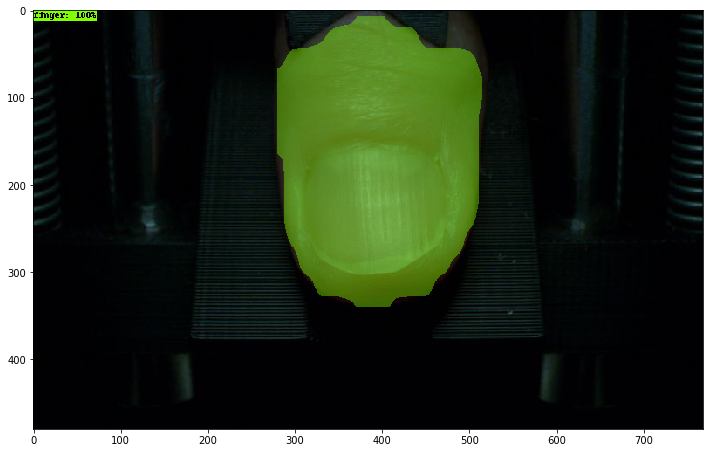

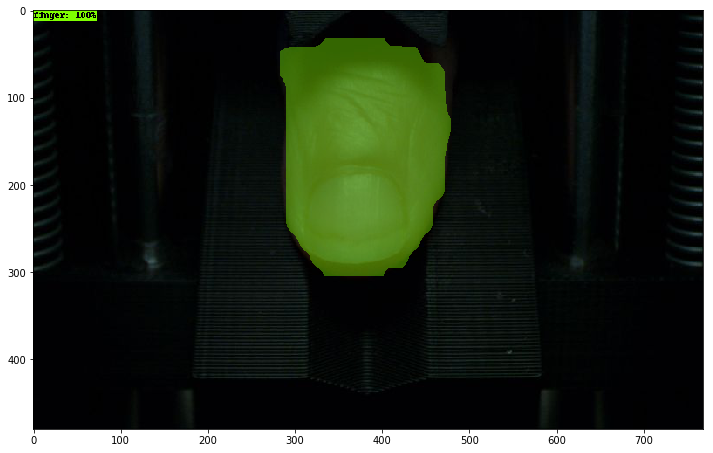

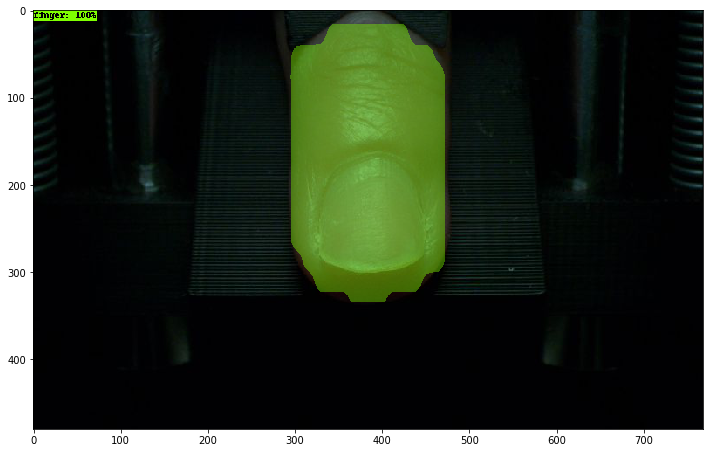

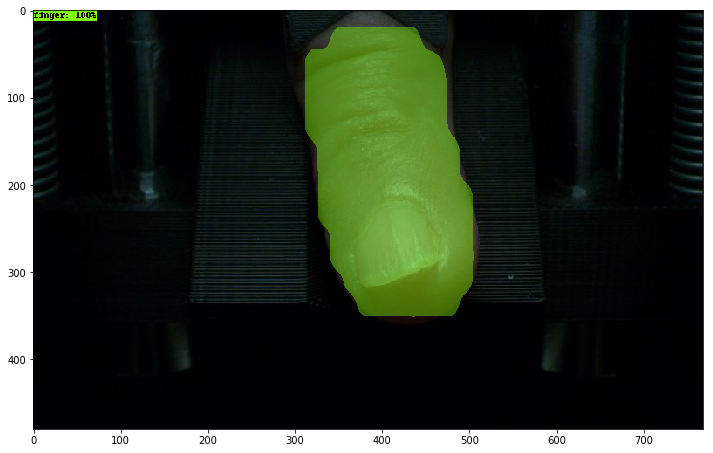

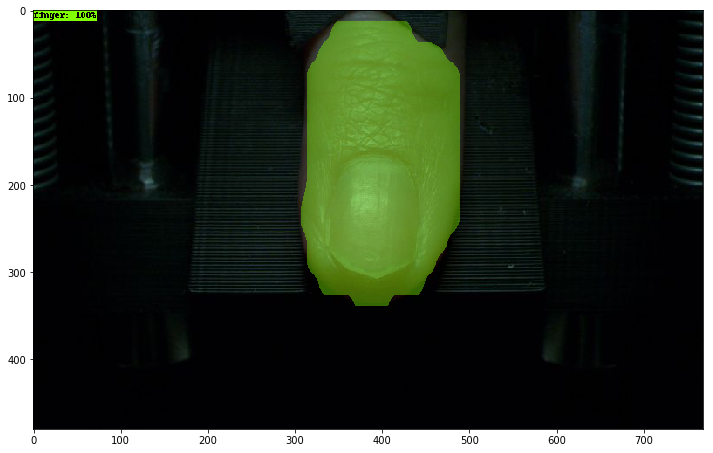

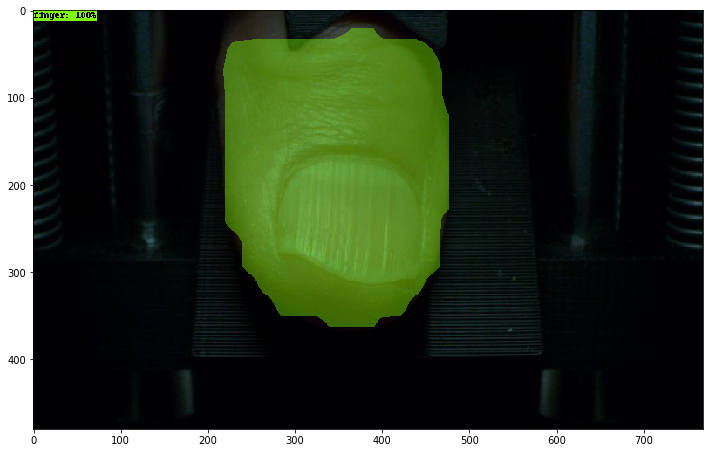

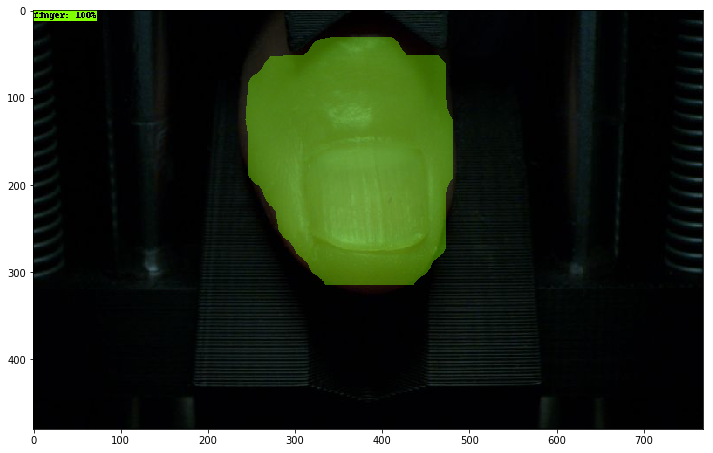

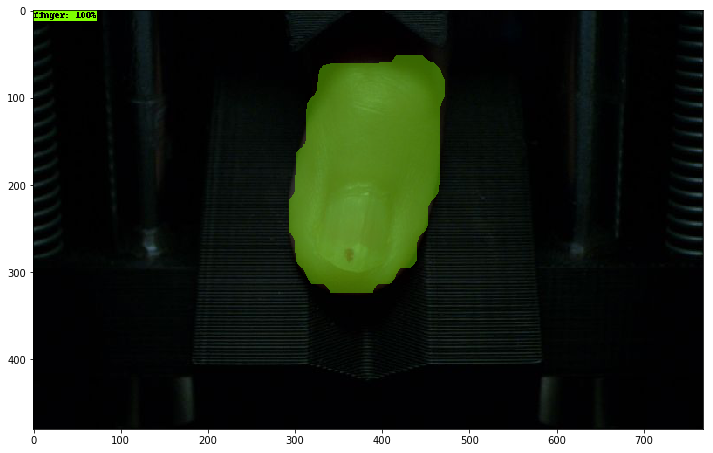

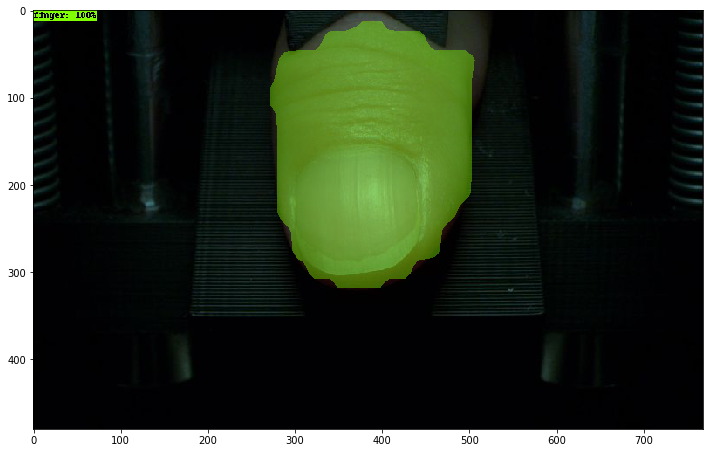

In [36]:
for image_path in TEST_IMAGE_PATHS:
  
  image = Image.open(image_path)
  
  
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)

  # Actual detection.

  output_dict = run_inference_for_single_image(image_np, detection_graph)

    
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(image_np,output_dict['detection_boxes']*0,[1, 1],[1.,0.],category_index,instance_masks=output_dict.get('detection_masks'),use_normalized_coordinates=True,line_thickness=1)
  #vis_util.visualize_boxes_and_labels_on_image_array(image_np,output_dict['detection_boxes']*0,output_dict['detection_classes'],output_dict['detection_scores'],category_index,instance_masks=output_dict.get('detection_masks'),use_normalized_coordinates=True,line_thickness=8)
  fig = plt.figure(figsize=IMAGE_SIZE)
  ax = fig.gca()
  ax.grid(False)
  plt.imshow(image_np)
  mask=output_dict.get('detection_masks')
  
  
  plt.imshow(image_np)
  Annotation_path=image_path.replace("testImages", "Annotations")
  Annotation_path=Annotation_path.replace("jpg", "png")
  ground_truth = Image.open(Annotation_path)
  ground_truth = np.reshape(np.array(ground_truth.getdata()),(480,768))
  pixel_accuracy_of_predicted_mask=pixel_accuracy(ground_truth, mask)
  IOU_of_predicted_mask=mean_IU(ground_truth, mask)
  print(pixel_accuracy_of_predicted_mask)
  print(IOU_of_predicted_mask)

  
  
  

In [ ]:
def run_inference_for_single_image1(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in ['detection_boxes', 'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(1, tf.int32)
        
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, 480, 768)
        detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict